# Quickstart
* [tutorial](http://lightkurve.keplerscience.org/tutorials/1.02-target-pixel-files.html)

In [1]:
import getpass
uname = getpass.getuser()

if uname == 'prometheus' or uname == 'jp':
    data_dir = '/home/'+uname+'/data/transit/c16-tpf/'
elif uname == 'muscat':
    data_dir = '../c16-tpf/'
else: 
    data_dir = '.'

# All C16 targets

In [2]:
import pandas as pd
import numpy as np

fname = '../data/K2Campaign16targets_edited.csv'

df=pd.read_csv(fname, index_col=0)#, dtype={' magnitude': float})

In [3]:
mag1012 = df.query('magnitude > 10 and magnitude < 12').sort_values(by='magnitude', ascending=True)

In [4]:
mag1012.head()

,EPIC ID,RA (J2000) [deg],Dec (J2000) [deg],magnitude,Investigation IDs
17217,211814879,133.287804,17.526790,10.001,GO16052_LC
12247,211629981,137.741823,14.956537,10.001,GO16052_LC
16681,211794319,136.919732,17.236207,10.005,GO16009_LC|GO16021_LC|GO16028_LC
17351,211818898,132.626847,17.584589,10.006,GO16052_LC
33359,251360161,137.580823,21.929321,10.006,GO16052_LC


To install the forked version of lightkurve with a simple patch:

In [5]:
import matplotlib.pyplot as pl
%matplotlib inline

import os
from glob import glob
import numpy as np
from astropy.io import fits
import pandas as pd

In [6]:
file_list = glob(data_dir+'/Yu2018_candidates/*.fits')
file_list.sort()
len(file_list)

31

Test

In [7]:
from lightkurve import KeplerTargetPixelFile

i = file_list[0]
tpf = KeplerTargetPixelFile(i, quality_bitmask='hardest')

In [8]:
np.sum(tpf.pipeline_mask)

0

In [9]:
import sys
sys.path.append('../K2tools')
from utils import *

times = tpf.time
fluxes = tpf.flux

aper_rad = 4
#masks
irregular_mask = make_mask(fluxes,cutoff_limit=1.0,shape='irregular')
round_mask  = make_mask(fluxes,rad=aper_rad,shape='round')
square_mask = make_mask(fluxes,rad=aper_rad,shape='square')

no_mask = make_mask(fluxes,shape='all')

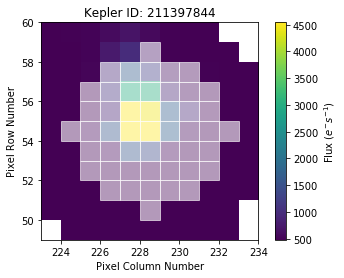

In [10]:
ax = tpf.plot(aperture_mask=round_mask, mask_color='w', frame=300,
              scale='linear', cmap='viridis', show_colorbar=True)

Pipeline mask is none, so 'all' pixels are used in generating lightcurve.

In [11]:
#lc = tpf.to_lightcurve(aperture_mask='all');
lc = tpf.to_lightcurve(aperture_mask=round_mask);

lc = lc.remove_nans().remove_outliers(sigma=3)
flat_lc, trend = lc.flatten(window_length=301, return_trend=True)

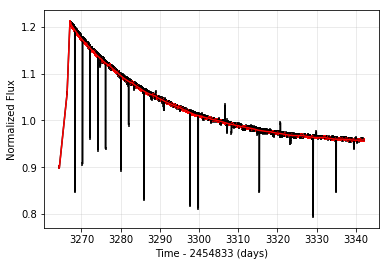

In [12]:
ax = lc.plot()                         
trend.plot(ax, color='red');

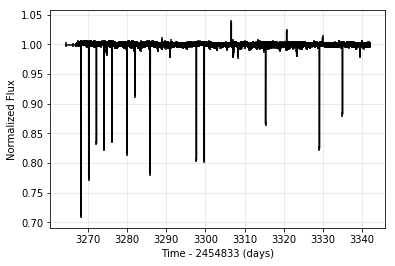

In [13]:
flat_lc.plot();

## sff manual

## sff function

100%|██████████| 30/30 [00:02<00:00, 13.99it/s]


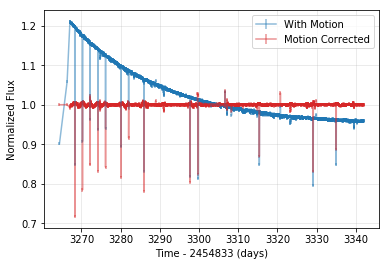

In [16]:
corr_lc = lc.correct(windows=30)

ax = lc.plot(color='C0', alpha=0.5, label='With Motion')

#corr_lc = corr_lc.remove_outliers(sigma=50.0)
ax = corr_lc.plot(ax=ax, color='C3', alpha=0.5, label='Motion Corrected');

In [17]:
#before, after
lc.cdpp(), corr_lc.cdpp()

(1674.6294123626492, 1827.9496691138122)

# Vanderburg data products

In [18]:
type(fits.open('../data/hlsp_k2sff_k2_lightcurve_060021426-cet_kepler_v1_llc.fits'))

astropy.io.fits.hdu.hdulist.HDUList

In [19]:
fits.open('../data/hlsp_k2sff_k2_lightcurve_060021426-cet_kepler_v1_llc.fits').info()

Filename: ../data/hlsp_k2sff_k2_lightcurve_060021426-cet_kepler_v1_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   ()      
  1  BESTAPER      1 BinTableHDU    240   312R x 6C   [D, D, D, D, I, J]   
  2  CIRC_APER0    1 BinTableHDU    240   312R x 6C   [D, D, D, D, I, J]   
  3  CIRC_APER1    1 BinTableHDU    240   312R x 6C   [D, D, D, D, I, J]   
  4  CIRC_APER2    1 BinTableHDU    240   312R x 6C   [D, D, D, D, I, J]   
  5  CIRC_APER3    1 BinTableHDU    240   312R x 6C   [D, D, D, D, I, J]   
  6  CIRC_APER4    1 BinTableHDU    240   312R x 6C   [D, D, D, D, I, J]   
  7  CIRC_APER5    1 BinTableHDU    240   312R x 6C   [D, D, D, D, I, J]   
  8  CIRC_APER6    1 BinTableHDU    240   312R x 6C   [D, D, D, D, I, J]   
  9  CIRC_APER7    1 BinTableHDU    240   312R x 6C   [D, D, D, D, I, J]   
 10  CIRC_APER8    1 BinTableHDU    240   312R x 6C   [D, D, D, D, I, J]   
 11  CIRC_APER9    1 BinTableHDU    240   312R x 6C

In [20]:
final_lc=pd.DataFrame(np.c_[corr_lc.time, corr_lc.flux, corr_lc.flux_err])
final_lc.columns = ['time','flux','flux_err']
final_lc.head()

,time,flux,flux_err
0,3264.367187,1.000000,0.003812
1,3266.328991,1.000236,0.004132
2,3267.044233,0.992186,0.004417
3,3267.085104,0.996675,0.004417
4,3267.105539,0.996600,0.004417


## Appending to the hdulist

In [21]:
from astropy import table

tab = table.Table(final_lc.values,
                  names=['time','flux','flux_err'])
tab

time,flux,flux_err
float64,float64,float64
3264.367186519783,1.0,0.0038121462719091057
3266.3289909511805,1.0002364269593604,0.004131967230511799
3267.0442327656783,0.9921864991211689,0.004417097648979965
3267.0851037316024,0.9966750641098583,0.004416823874774623
3267.1055393149145,0.9966003932873111,0.004417038068622328
3267.187281251885,0.993705113073612,0.004417402936762902
3267.30989416549,0.9985085685519831,0.004413910838445834
3267.3303297520615,0.9972255625206947,0.004412697565708488
3267.3507651388645,0.9987585525068303,0.004412278533606426


In [22]:
fname = file_list[1]

In [28]:
from astropy.io import fits

#i = file_list[-1]
hdr = fits.getheader(i)
hdulist = fits.open(i)
assert str(tpf.keplerid) in hdulist.filename()

num = 1
comment_num = 'COMMENT{}'.format(num)

#llc-default-aper
aper = 'default'
hdr[comment_num] = 'aper rad: {}'.format(aper)
bintab=fits.BinTableHDU(tab,name='BESTAPER',header=hdr)
#append to original
hdulist.append(bintab)

In [29]:
hdu=fits.hdu.ImageHDU(np.array(aperture,dtype=float), name='APERTURE', header=hdr) #problem with bool

#hdulist.append(hdu)
#replace aperture
hdulist[2] = hdu

In [30]:
hdulist.info()

Filename: /home/jp/data/transit/c16-tpf/Yu2018_candidates/ktwo211397844-unofficial-tpf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  TARGETTABLES    1 BinTableHDU    284   3888R x 12C   [D, E, J, 121J, 121E, 121E, 121E, 121E, 121E, J, E, E]   
  2  APERTURE      1 ImageHDU        59   (11, 11)   float64   
  3  BESTAPER      1 BinTableHDU     68   3617R x 3C   ['D', 'D', 'D']   


In [24]:
radii = np.arange(3,6,1)

flux_per_r, aper_mask = aper_phot_multi(tpf,radii,aper_shape='round')

  0%|          | 0/30 [00:00<?, ?it/s]

Aperture photometry with r=[3 4 5] and round mask...



100%|██████████| 30/30 [00:02<00:00, 12.74it/s]


# lightkurve script

# All Yu+2018 candidates

In [32]:
def engine(fname, sigma = 3,flat_window = 301,corr_window = 51,
           cutoff_limit = 1.0,polyorder=4,break_tolerance=5):
    #read tpf
    tpf = KeplerTargetPixelFile(fname, quality_bitmask='hardest')
    #confirm aperture
    times, fluxes = tpf.time, tpf.flux
    aperture = find_aperture(times,fluxes,starname=tpf.keplerid)
    tpf.plot(aperture_mask=aperture)
    #convert to lightcurve
    lc = tpf.to_lightcurve(aperture_mask=aperture)
    #clean 
    lc = lc.remove_nans().remove_outliers(sigma=sigma)
    #correcting for low freq variability
    flat_lc, trend = lc.flatten(window_length=flat_window,
                        polyorder=polyorder,
                        break_tolerance=break_tolerance, 
                        return_trend=True)
    ax = lc.plot(color='C0', label='raw')                         
    trend.plot(ax=ax, color='C3',label='systematics');
    #correct for systematics using sff
    corr_lc = lc.correct(windows=corr_window, method='sff')

    #corr_lc = corr_lc.remove_outliers(sigma=10)
    #comparison
    ax2 = lc.plot(color='C0', alpha=0.5, label='With Motion')
    corr_lc.plot(ax=ax2, color='C3', alpha=0.5, label='Motion Corrected');

    #cdpp = noise_statistic(corr_lc.time, corr_lc.flux,verbose=True)
    cdpp = corr_lc.cdpp()
    return corr_lc

[Yu+2018]() candidates

In [25]:
import pandas as pd
import numpy as np

fname = '../data/Yu2018_candidates.csv'

df2=pd.read_csv(fname, index_col=0)#, dtype={'Candidate': float})
df2.index = df2.index.astype(int)
df2.head()

,Kp,P[d],T0 [BJD-2454833],T14,(Rs/Rs)^2,Rs[Rsun],Teff[K],Rp[Re],Sinc[Fe],Comment
Candidate,,,,,,,,,,
211397844,13.292,16.166729,3274.81627,0.1331,4653,3.5,4937,26.3,383.0,None
211502222,11.617,22.996469,3280.30463,0.1550,515,1.4,6110,3.5,91.0,None
211529065,13.431,4.399372,3264.74269,0.0532,1156,0.7,4701,2.6,95.0,None
211533633,13.258,2.127017,3262.65841,0.0590,724,0.5,3992,1.3,70.0,None
211552050,13.194,3.545471,3264.94603,0.0610,607,0.7,4639,1.8,111.0,None


In [47]:
#get moderately bright candidates
sample = df2.query('Kp > 10 and Kp < 12').sort_values(by='Kp', ascending=True)
epics = sample.index.values
epics

array([211945201, 212099230, 212036875, 212058012, 251319382, 211730024,
       212110888, 211502222, 211647930])

# lightkurve script

In [ ]:
for i in epics:
    fname = glob(data_dir+'/*{}*.fits'.format(i))[0]
    try:
        engine(fname, sigma = 3,flat_window = 301,corr_window = 51,
           cutoff_limit = 1.0,polyorder=4,break_tolerance=5)
    except:
        print(i)

## Period search

In [33]:
from gatspy.periodic import LombScargleFast

model=LombScargleFast(fit_period=True)

model.optimizer.period_range = (1, 10)

model.fit(flat_lc.time, flat_lc.flux, flat_lc.flux_err)

Finding optimal frequency:
 - Estimated peak width = 0.0809
 - Using 5 steps per peak; omega_step = 0.0162
 - User-specified period range:  1 to 10
 - Computing periods at 351 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


In [34]:
p=model.best_period
p

1.9615991747529744

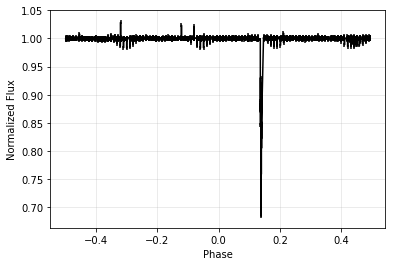

In [35]:
folded_lc = flat_lc.fold(period=p)
folded_lc.plot();

# Vdb data

# C16 data

100%|██████████| 11/11 [00:01<00:00,  8.45it/s]


cdpp = 0.0005


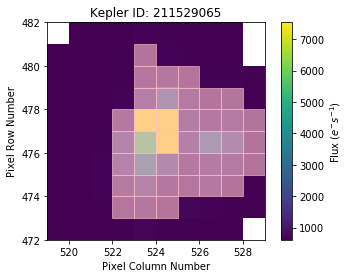

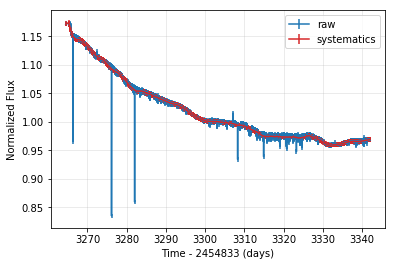

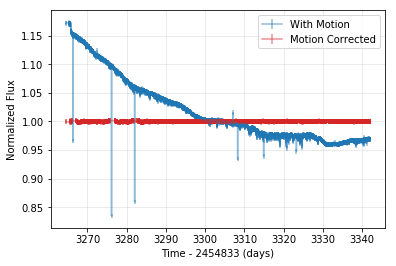

In [36]:
from lightkurve import KeplerTargetPixelFile

sigma = 3
flat_window = 301
corr_window = 11
cutoff_limit = 1.1
polyorder=4
break_tolerance=5

i = file_list[2]
#read tpf
tpf = KeplerTargetPixelFile(i, quality_bitmask='hardest')

times, fluxes = tpf.time, tpf.flux
#confirm aperture
aperture = find_aperture(times,fluxes,cutoff_limit=cutoff_limit,starname=tpf.keplerid)
tpf.plot(aperture_mask=aperture)
#convert to lightcurve
lc = tpf.to_lightcurve(aperture_mask=aperture)
#clean 
lc = lc.remove_nans().remove_outliers(sigma=sigma)
#correcting for low freq variability
flat_lc, trend = lc.flatten(window_length=flat_window,
                            polyorder=polyorder,
                            break_tolerance=break_tolerance, 
                            return_trend=True)
ax = lc.plot(color='C0', label='raw')                         
trend.plot(ax=ax, color='C3',label='systematics');
#correct for systematics using sff
corr_lc = lc.correct(windows=corr_window, method='sff')
corr_lc = corr_lc.remove_outliers(sigma)
#comparison
ax2 = lc.plot(color='C0', alpha=0.5, label='With Motion')
corr_lc.plot(ax=ax2, color='C3', alpha=0.5, label='Motion Corrected');

cdpp = noise_statistic(corr_lc.time, corr_lc.flux, verbose=True)

In [37]:
len(file_list)

31

  0%|          | 0/51 [00:00<?, ?it/s]/home/jp/miniconda3/envs/astroconda35/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:595: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/jp/miniconda3/envs/astroconda35/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:598: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/jp/miniconda3/envs/astroconda35/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:155: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/home/jp/miniconda3/envs/astroconda35/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:156: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value



/home/jp/data/transit/c16-tpf/Yu2018_candidates/ktwo211397844-unofficial-tpf.fits


100%|██████████| 51/51 [00:02<00:00, 18.60it/s]


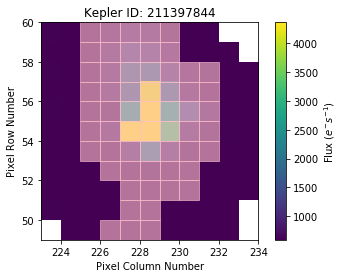

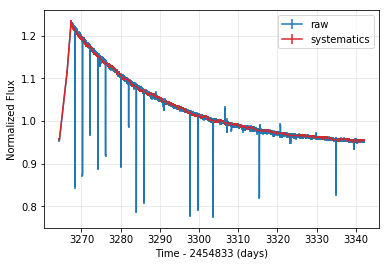

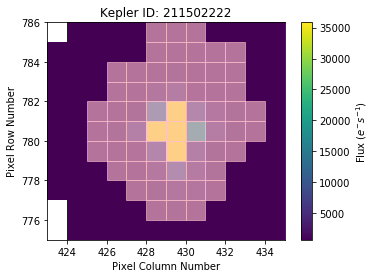

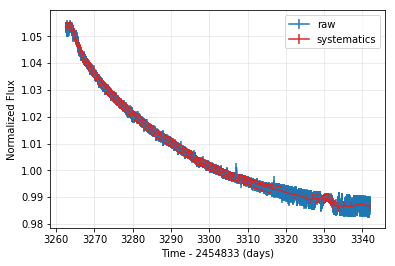

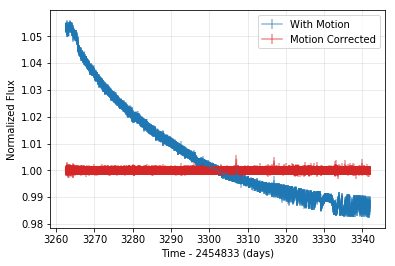

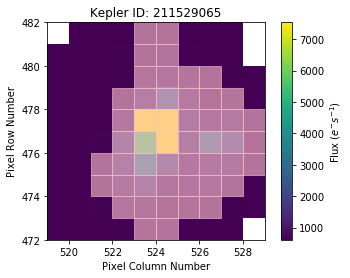

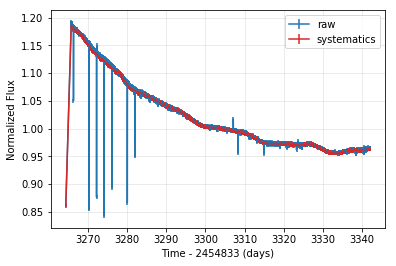

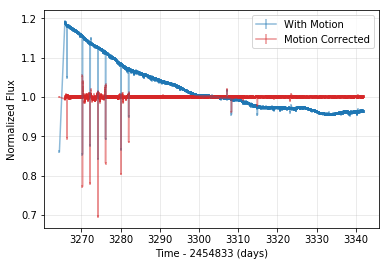

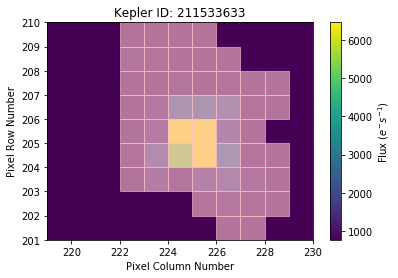

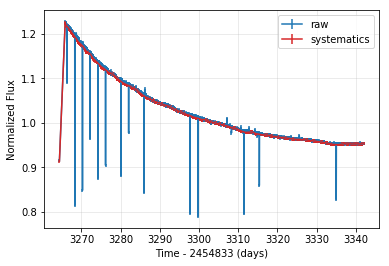

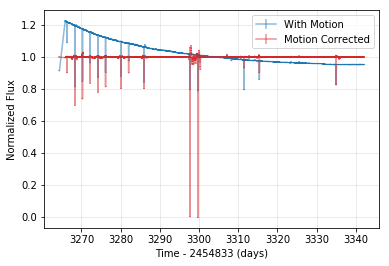

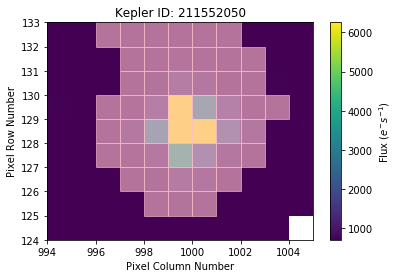

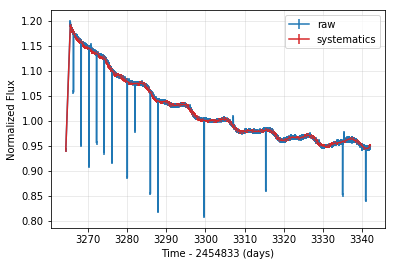

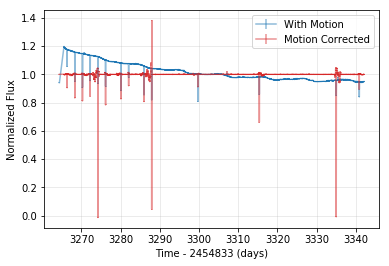

In [50]:
sigma = 3
flat_window = 301
corr_window = 51
cutoff_limit = 1.0
polyorder=4
break_tolerance=5

for i in file_list[:5]:
    try:
        engine(i, sigma = 3,flat_window = 301,corr_window = 51,
           cutoff_limit = 1.0,polyorder=4,break_tolerance=5)
    except:
        print(i)

100%|██████████| 51/51 [00:02<00:00, 17.03it/s]


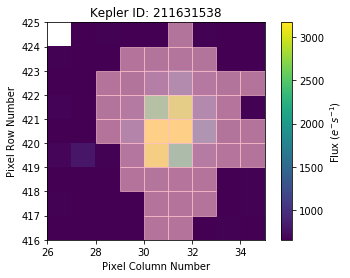

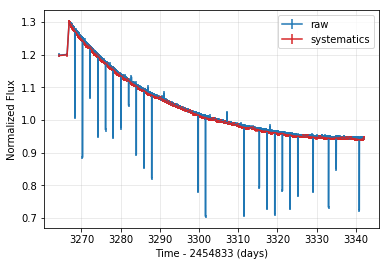

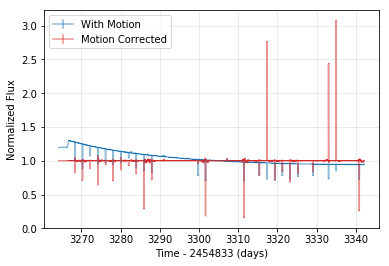

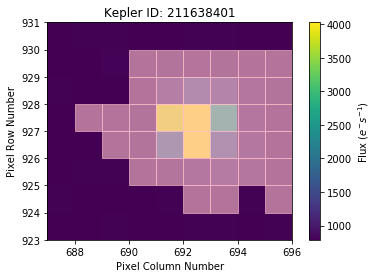

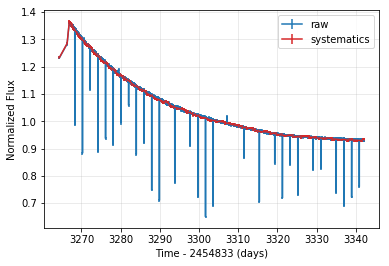

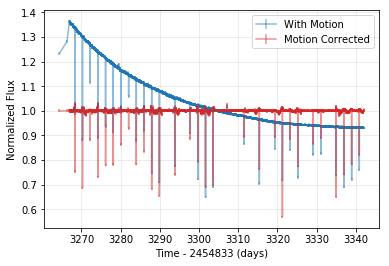

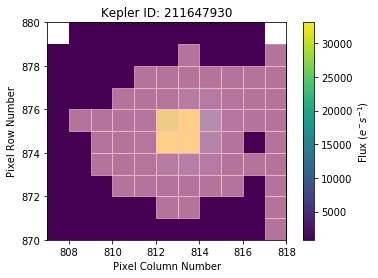

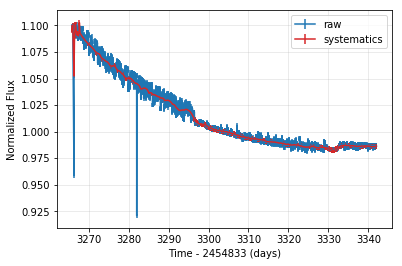

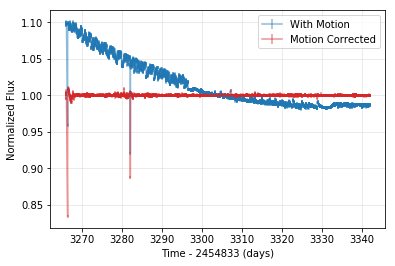

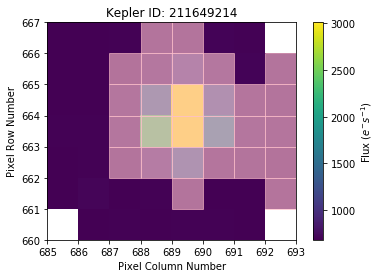

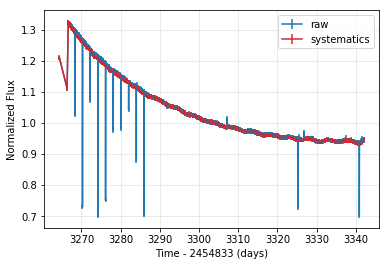

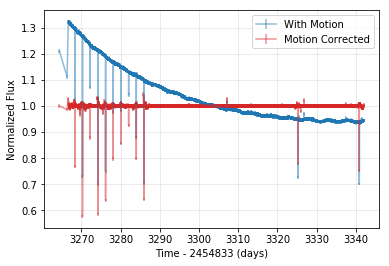

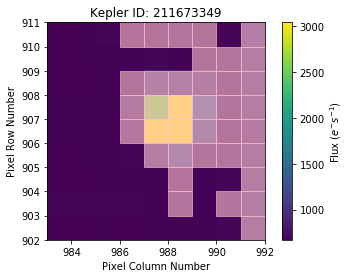

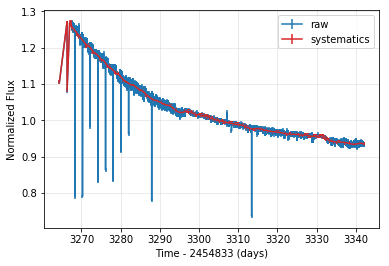

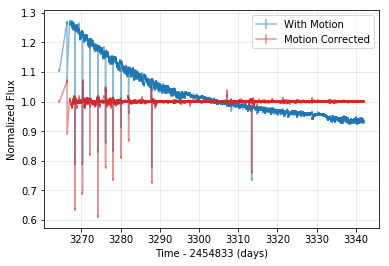

In [51]:
for i in file_list[5:10]:
    try:
        engine(i, sigma = 3,flat_window = 301,corr_window = 51,
           cutoff_limit = 1.0,polyorder=4,break_tolerance=5)
    except:
        print(i)

100%|██████████| 51/51 [00:02<00:00, 18.97it/s]


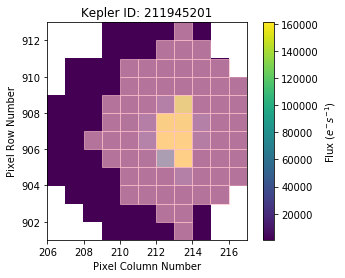

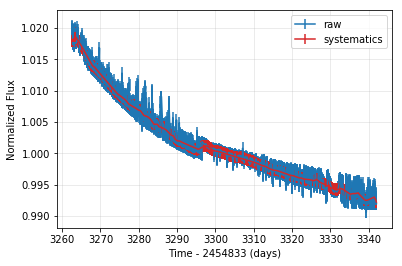

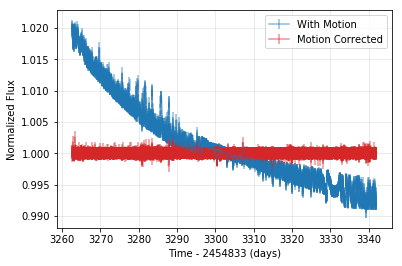

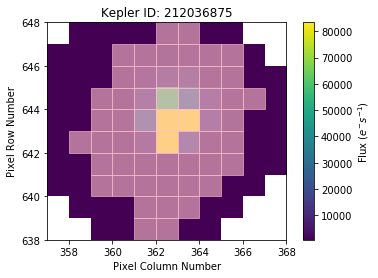

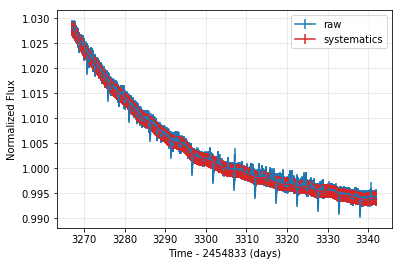

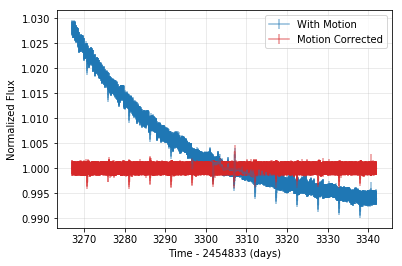

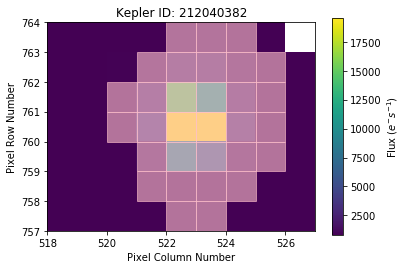

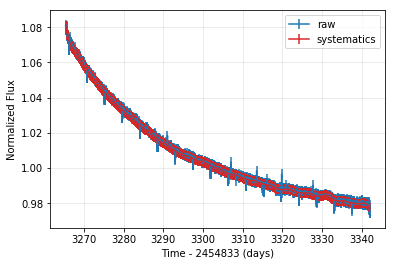

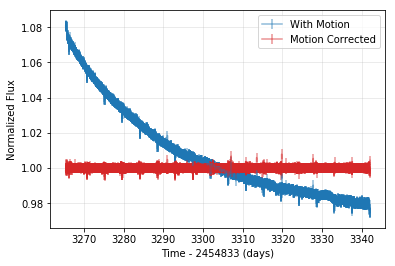

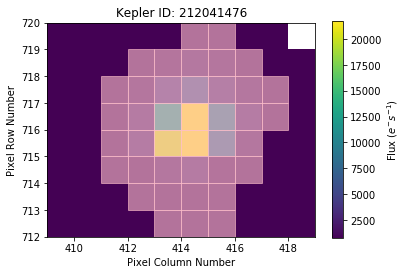

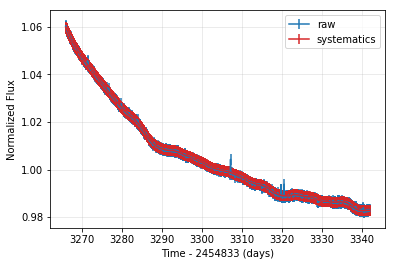

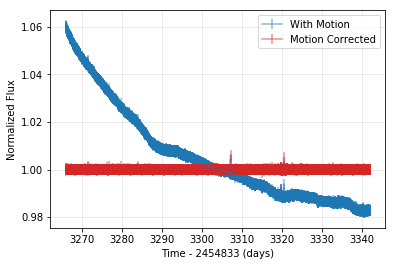

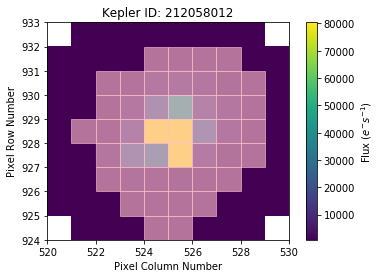

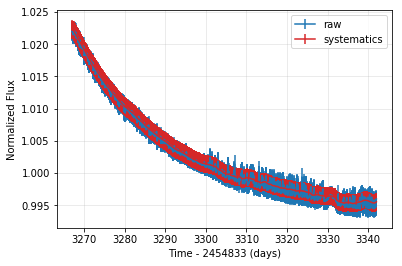

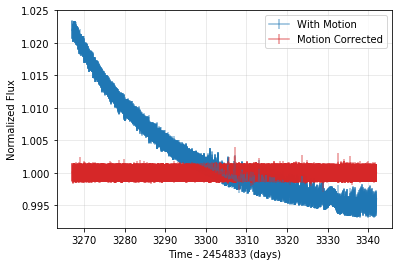

In [52]:
for i in file_list[15:20]:
    try:
        engine(i, sigma = 3,flat_window = 301,corr_window = 51,
           cutoff_limit = 1.0,polyorder=4,break_tolerance=5)
    except:
        print(i)

100%|██████████| 51/51 [00:02<00:00, 17.54it/s]


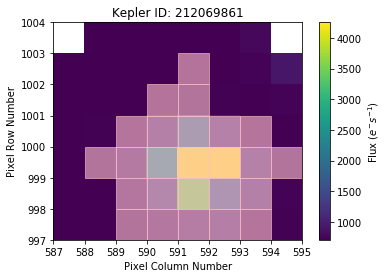

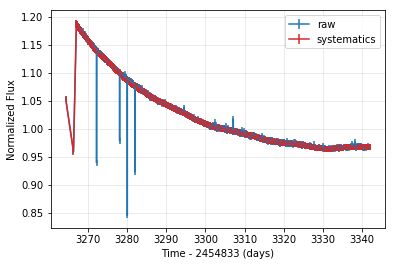

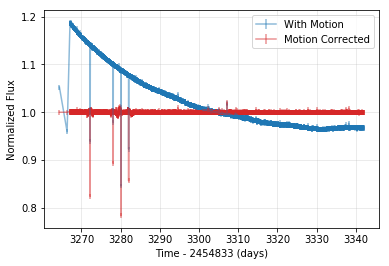

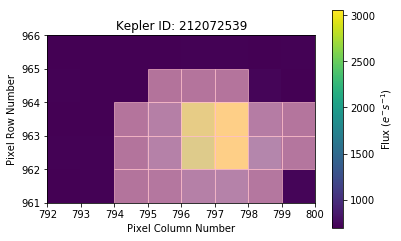

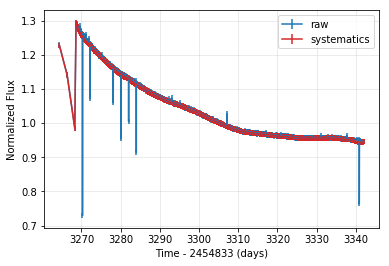

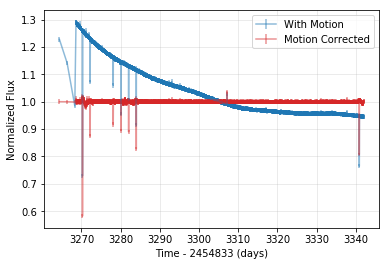

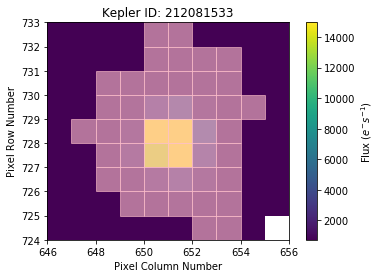

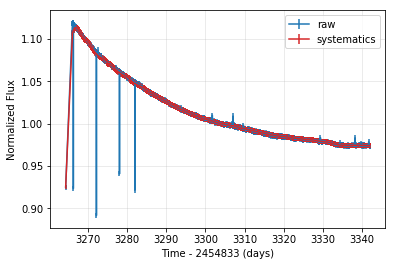

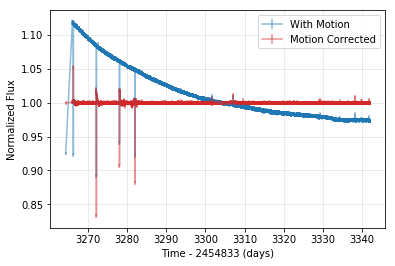

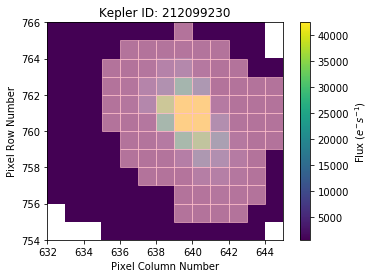

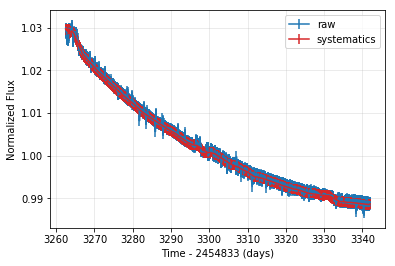

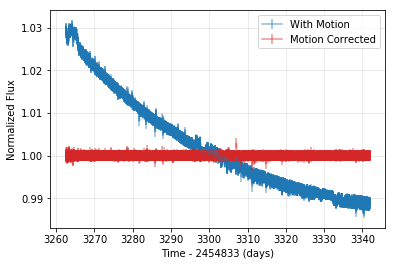

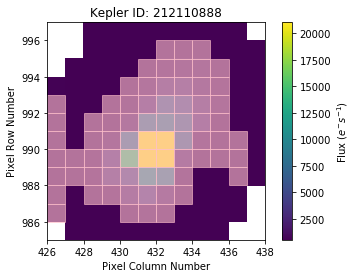

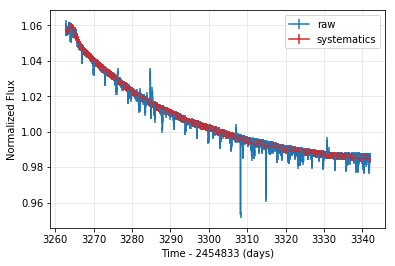

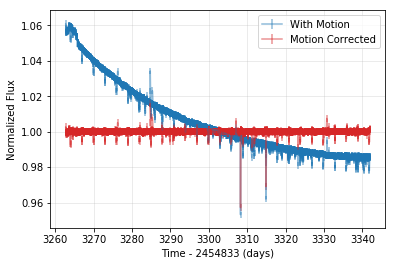

In [53]:
for i in file_list[20:25]:
    try:
        engine(i, sigma = 3,flat_window = 301,corr_window = 51,
           cutoff_limit = 1.0,polyorder=4,break_tolerance=5)
    except:
        print(i)

100%|██████████| 51/51 [00:02<00:00, 17.90it/s]


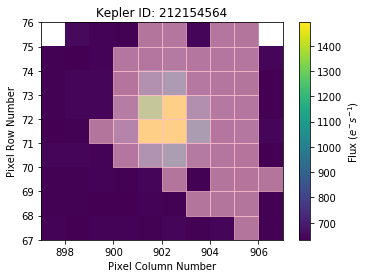

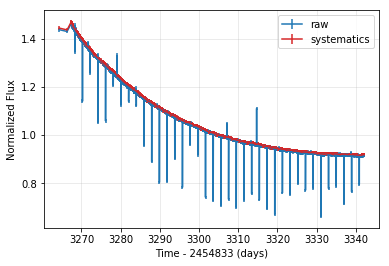

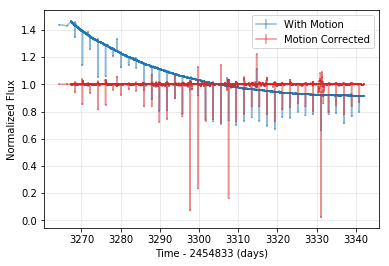

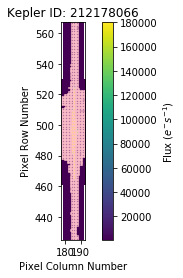

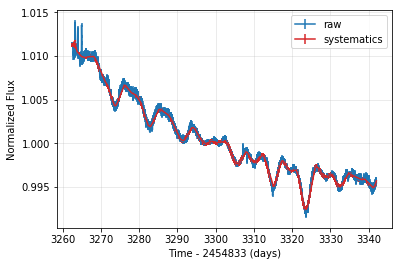

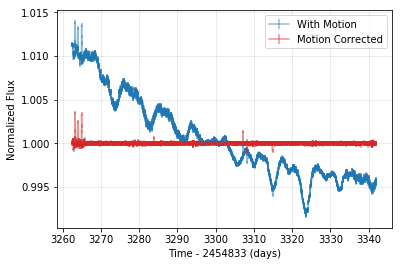

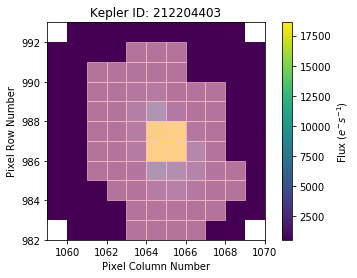

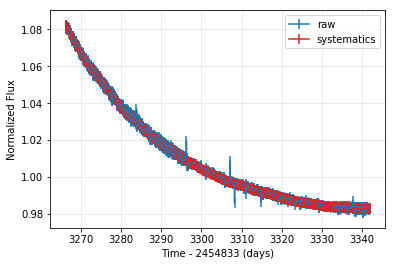

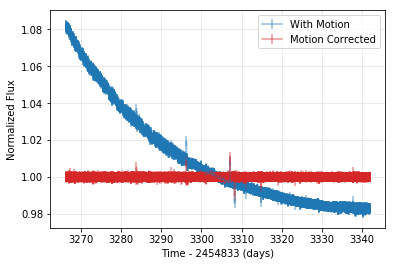

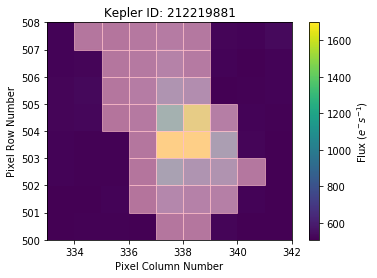

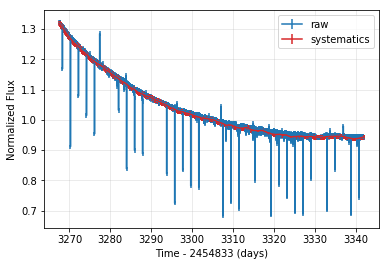

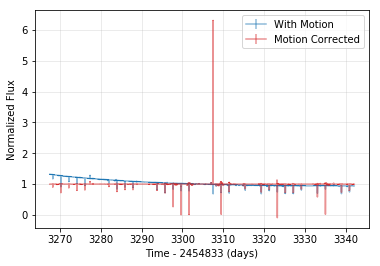

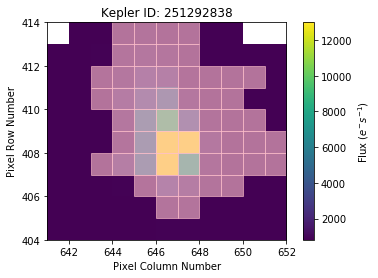

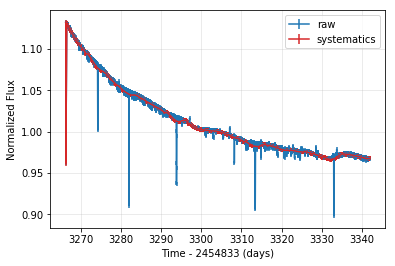

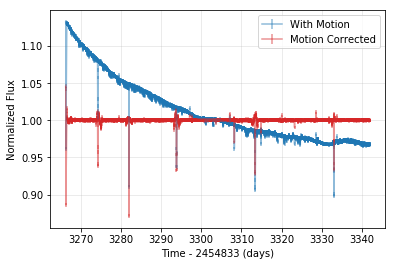

In [54]:
for i in file_list[25:30]:
    try:
        engine(i, sigma = 3,flat_window = 301,corr_window = 51,
           cutoff_limit = 1.0,polyorder=4,break_tolerance=5)
    except:
        print(i)

In [40]:
mask = corr_lc.flux<0.5
t,f,e = corr_lc.time[~mask], corr_lc.flux[~mask], corr_lc.flux_err[~mask]

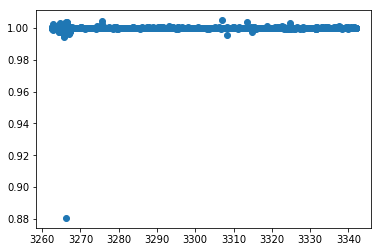

In [41]:
pl.plot(t,f,'o')

In [42]:
import gatspy
from gatspy.periodic import LombScargleFast # see also LombScargleAstroML

thin = 1
model = LombScargleFast().fit(t[::thin], f[::thin], e[::thin])
periods, power = model.periodogram_auto(nyquist_factor=100)

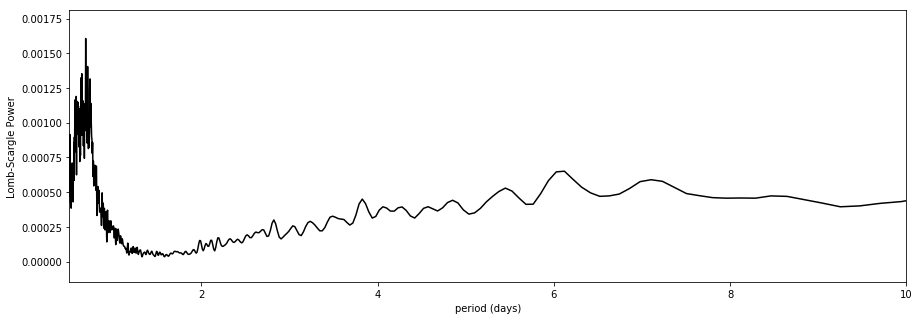

In [43]:
idx1 = periods > 1
idx2 = np.argmax(power[idx1])
peak = periods[idx1][idx2]

fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(periods, power, 'k-')
ax.set(xlim=(0.5, 10),
#         , ylim=(0, 0.01),
   xlabel='period (days)',
   ylabel='Lomb-Scargle Power')
ax.vlines(peak, *ax.get_ylim(), linestyles='dotted', colors='r')

In [44]:
peak

397.7762767719105

In [45]:
#optimization
# set range and find period
model.optimizer.period_range=(2, 3)
peak = model.best_period
print("period = {0}".format(peak))

Finding optimal frequency:
 - Estimated peak width = 0.079
 - Using 5 steps per peak; omega_step = 0.0158
 - User-specified period range:  2 to 3
 - Computing periods at 68 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 2.8184679360290983


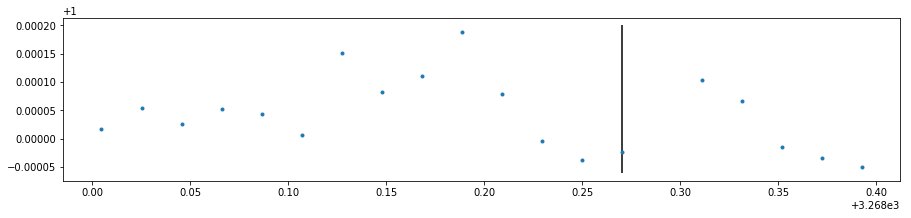

In [46]:
idx = (3268 < t) & (t < 3268.4)
tsub, fsub = t[idx], f[idx]
idx = fsub < np.median(fsub) - 0.5 * np.std(fsub)
t0 = np.median(tsub[idx])

fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(tsub, fsub, '.')
ax.vlines(t0, *ax.get_ylim())

In [47]:
#import simfit
#tf, ff = simfit.util.fold(t, f, peak, t0)

def get_tns(t, p, t0):

    idx = t != 0
    t = t[idx]

    while t0-p > t.min():
        t0 -= p
    if t0 < t.min():
        t0 += p

    tns = [t0+p*i for i in range(int((t.max()-t0)/p+1))]

    while tns[-1] > t.max():
        tns.pop()

    while tns[0] < t.min():
        tns = tns[1:]

    return tns


def fold(t, f, p, t0, width=0.4, clip=False, bl=False, t14=0.2):
    tns = get_tns(t, p, t0)
    tf, ff = np.empty(0), np.empty(0)
    for i,tn in enumerate(tns):
        idx = (t > tn - width/2.) & (t < tn + width/2.)
        ti = t[idx]-tn
        fi = f[idx]
        fi /= np.nanmedian(fi)
        if bl:
            idx = (ti < -t14/2.) | (ti > t14/2.)
            assert np.isfinite(ti[idx]).all() & np.isfinite(fi[idx]).all()
            assert idx.sum() > 0
            try:
                res = sm.RLM(fi[idx], sm.add_constant(ti[idx])).fit()
                if np.abs(res.params[1]) > 1e-2:
                    print('bad data probably causing poor fit')
                    print('transit {} baseline params: {}'.format(i, res.params))
                    continue
                model = res.params[0] + res.params[1] * ti
                fi = fi - model + 1
            except:
                print("error computing baseline for transit {}".format(i))
                print("num. points: {}".format(idx.sum()))
                print(ti)
        tf = np.append(tf, ti)
        ff = np.append(ff, fi / np.nanmedian(fi))
    idx = np.argsort(tf)
    tf = tf[idx]
    ff = ff[idx]
    if clip:
        fc = sigma_clip(ff, sigma_lower=10, sigma_upper=2)
        tf, ff = tf[~fc.mask], ff[~fc.mask]
    return tf, ff

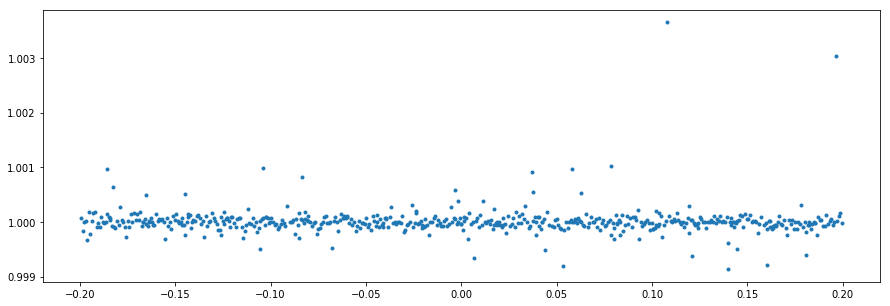

In [48]:
tf, ff = fold(t, f, peak, t0)

fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(tf, ff, '.')